# XGBoost for Classification Example

To read further about XGBoost *[Click Here](https://www.geeksforgeeks.org/xgboost/)*. <br>XGBoost Mathematical Intuition *[Click Here](https://medium.com/@prathameshsonawane/xgboost-how-does-this-work-e1cae7c5b6cb/)*.


## Importing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
# This is the classifier
from xgboost import XGBClassifier
# This is the function that helps plot feature importance 
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
# This displays all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)
# This module lets us save our models once we fit them.

In [2]:
# Read in data
file = 'Churn_Modelling.csv'
df_original = pd.read_csv(file)
# removing unnecessary columns
df_original.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)
df_original.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [4]:
# Converting categorical values, in case of binary, to numeric
# df_original['Gender'] = df_original['Gender'].map({'Male': 1, 'Female':0})
df_original['Gender'].value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

In [5]:
# Now Checking Different levels in Geography Column
df_original['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

## Feature transformation
Next, we'll dummy encode the Geography and Gender variable, which are categorical. 
We do this with the 
pd.get_dummies() function and setting drop_first='True' , which replaces the
Geography column with two new Boolean columns called Geography_Germany and
Geography_Spain
and Gender column one new Boolean column Gender_Male

In [6]:
transformed_df = pd.get_dummies(data=df_original, drop_first=True)
transformed_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


In [7]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  int64  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  bool   
 10  Geography_Spain    10000 non-null  bool   
 11  Gender_Male        10000 non-null  bool   
dtypes: bool(3), float64(2), int64(7)
memory usage: 732.6 KB


#### Alternatively, we can use sklearns's OneHotEncoder class
provides same results as pd.get_dummies() [which also provides new column namings by deault]

In [8]:
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder(drop='first', sparse_output=False, dtype = np.int32)

# transformed_cols = enc.fit_transform(df_original[['Geography','Gender']])
# # converts the transformed columns into dataframe
# transformed_cols_as_df = pd.DataFrame(transformed_cols, 
#                                       columns= enc.get_feature_names_out(
#                                           input_features=enc.feature_names_in_))
# # concatinating the transfrmed columns in original set
# df_encoded = pd.concat([transformed_cols_as_df, df_original], axis=1).drop(columns=enc.feature_names_in_)
# df_encoded.head()
# df_encoded.info()

## Split the data

In [9]:
y = transformed_df['Exited']
X = transformed_df.drop('Exited', axis = 1)

print(X.shape, y.shape)

(10000, 11) (10000,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6700, 11)
(6700,)
(3300, 11)
(3300,)


## Model Training with Cross-Validation

1. Instantiate the classifier (and set the random_state ). Note here that we've included a
    parameter called objective whose value is binary:logistic as it's a binary classification.
2. Create a dictionary of hyperparameters to search over.
3. Create a dictionary of scoring metrics to capture.
4. Instantiate the GridSearchCV object. Pass as arguments:
     - The classifier ( xgb )
     - The dictionary of hyperparameters to search over ( cv_params )
     - The dictionary of scoring metrics ( scoring )
     - The number of cross-validation folds you want ( cv=5 )
     - The scoring metric that you want GridSearch to use when it selects the "best" model
       (i.e., the model that performs best on average over all validation folds) ( refit='f1' )

5. Fit the data ( X_train , y_train ) to the GridSearchCV object (xgb_cv)

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
xgb = XGBClassifier(objective='binary:logistic')
cv_params = {'max_depth': [4,5,6,7,8],
            'min_child_weight': [1,2,3,4,5],
            'learning_rate': [0.1, 0.2, 0.3],
            'n_estimators': [75, 100, 125]
           } 

scoring_method = ['accuracy', 'precision', 'recall','f1']

xgb_validated = GridSearchCV(estimator=xgb, 
                             param_grid=cv_params, 
                             scoring=scoring_method, 
                             n_jobs= -1,
                             cv = 5,
                             refit = 'f1',
                             verbose=3
                            )

In [15]:
%%time
xgb_validated.fit(X_train, y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
CPU times: total: 4.5 s
Wall time: 38.7 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [75, 100, 125]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'],
             verbose=3)

In [26]:
print(xgb_validated.best_params_)
print(xgb_validated.best_estimator_)
print(xgb_validated.best_score_)

{'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 125}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=125, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
0.6005220127732829


## Confusion Matrix

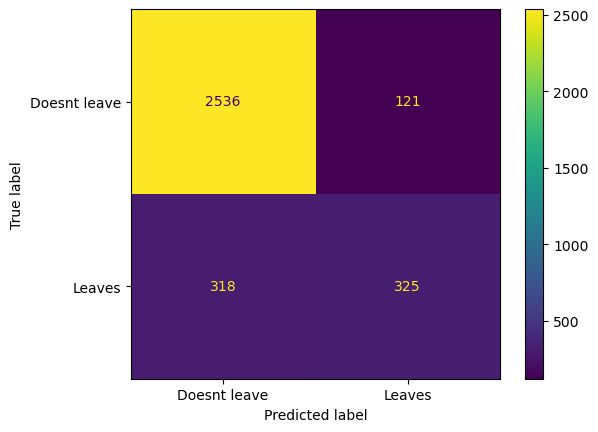

In [34]:
from sklearn.metrics import confusion_matrix
# Create helper function to plot confusion matrix
def conf_matrix_plot(model, X_data, y_data):
     '''
     Accepts as argument model object, X data (test or validate), and y data (te
     Returns a plot of confusion matrix for predictions on y data.
     '''
     model_pred = model.predict(X_data)
     cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
     disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=['Doesnt leave', 'Leaves']
                                  )
     
     disp.plot()
     plt.show()


conf_matrix_plot(xgb_validated, X_test, y_test)

## Feature importancehe XGBoost library has a function called plot_importance , which we imported at the
beginning of this notebook. This let's us check the features selected by the model as the most
predictive. We can create a plot by calling this function and passing to it the best estimator from
our grid searh.


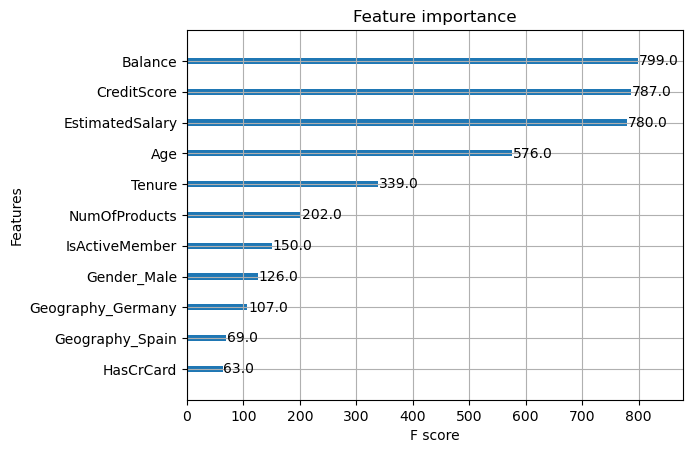

In [36]:
plot_importance(xgb_validated.best_estimator_);